# Aim

A full implementation of the SPRIGHT algorithm, as in [2].

In [24]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [25]:
def fwht(x):
    """Recursive implementation of the 1D Cooley-Tukey FFT"""
    # x = np.asarray(x, dtype=float)
    N = x.shape[0]
    if N == 1:
        return x
    else:
        X_even = fwht(x[0:(N//2)])
        X_odd = fwht(x[(N//2):])
        return np.concatenate([(X_even + X_odd),
                               (X_even - X_odd)])
    
def bin_to_dec(x):
    n = len(x)
    c = 2**(np.arange(n)[::-1])
    return c.dot(x).astype(np.int)

def dec_to_bin(x, num_bits):
    assert x < 2**num_bits, "number of bits are not enough"
    u = bin(x)[2:].zfill(num_bits)
    u = list(u)
    u = [int(i) for i in u]
    return np.array(u)

def binary_ints(n):
    '''
    Returns a matrix where row 'i' is dec_to_bin(i, n), for i from 0 to 2 ** n - 1.
    https://stackoverflow.com/questions/28111051/create-a-matrix-of-binary-representation-of-numbers-in-python
    '''
    a = np.arange(2 ** n, dtype=int)[np.newaxis,:]
    b = np.arange(n, dtype=int)[::-1,np.newaxis]
    return np.array(a & 2**b > 0, dtype=int)

In [26]:
def make_input_signal(n, loc, strengths, noise_sd):
    '''
    Arguments
    ---------
    n : int
    number of bits
    
    loc : iterable
    Locations of peaks in the W-H spectrum. Elements must be integers in [0, 2 ** n - 1].
    
    strengths : iterable
    The strength of each peak in the W-H spectrum. Defaults to all 1s. Dimension has to match that of loc.
    
    noise_sd : scalar
    The SD of the added noise.
    
    Returns
    -------
    input_signal : numpy.ndarray
    The time signal.
    
    input_wht : numpy.ndarray
    The WHT of input_signal.
    '''
    N = 2 ** n
    if strengths is None:
        strengths = np.ones_like(loc)
    input_wht = np.zeros((N,))
    for l, s in zip(loc, strengths):
        input_wht[l] = s
    input_signal = fwht(input_wht) + np.random.normal(0, noise_sd, (N,))
    return input_signal, fwht(input_signal) / N

class InputSignal:
    def __init__(self, n, loc, strengths=None, noise_sd=0):
        self.n = n
        self.noise_sd = noise_sd
        self.signal_t, self.signal_w = make_input_signal(n, loc, strengths, noise_sd)


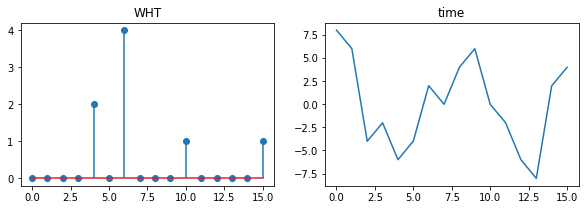

In [27]:
# make signal and plot it
input_signal = InputSignal(4, [4, 6, 10, 15], strengths=[2, 4, 1, 1], noise_sd=0.01)
noiseless_signal = InputSignal(4, [4, 6, 10, 15], strengths=[2, 4, 1, 1], noise_sd=0)
fig, axs = plt.subplots(1,2, figsize=(10,3))

axs[0].stem(input_signal.signal_w, use_line_collection=True)
axs[0].set_title('WHT')

axs[1].plot(input_signal.signal_t)
axs[1].set_title('time')
plt.show()

In [28]:
def subsample_indices(b, M, d):
    '''
    Query generator: creates indices for signal subsamples.
    
    Arguments
    ---------
    b : int
    The subsampling coefficient; subject to b <= n = log2(N).
    
    M : numpy.ndarray, shape (n, b)
    The subsampling matrix; takes on binary values.
    
    d : numpy.ndarray, shape (n,)
    The subsampling offset; takes on binary values.
    
    Returns
    -------
    indices : numpy.ndarray, shape (B,)
    The (decimal) subsample indices. Mostly for debugging purposes.
    
    subsamples : numpy.ndarray, shape (B,)
    The subsampled time signal.
    '''
    B = 2 ** b
    L = binary_ints(b)
    indices = bin_to_dec(np.mod(np.dot(M, L).T + d, 2).T)
    return indices

In [29]:
# implementing the example in the paper section 2.2

M1 = np.vstack((np.zeros((2,2)), np.eye(2)))
M2 = np.vstack((np.eye(2), np.zeros((2,2))))

In [30]:
# check linear combinations of subsampling
M1_subsampled_wht = fwht(input_signal.signal_t[subsample_indices(2, M1, np.zeros(4,))]) / 4
assert np.allclose(M1_subsampled_wht, np.array([np.sum([input_signal.signal_w[i::4]]) for i in range(4)]))

In [31]:
def singleton_detection_noiseless(U_slice):
    '''
    Finds the true index of a singleton, assuming that it is one.
    Works on a fixed M, and assumes P = n + 1 and D = [0; I]
    
    Arguments
    ---------
    U_slice : numpy.ndarray, (P,).
    The WHT component of the subsampled bin we care about, at diff delays.
    d[0] is the zero array, I think (is this necessary? probably)
    
    Returns
    -------
    k : numpy.ndarray
    Index of the corresponding right node, in binary form.
    '''
    return (-np.sign(U_slice * U_slice[0])[1:]/2 + 1/2).astype(np.int)

def singleton_detection(U_slice, selection, S, n):
    '''
    TODO: 
    - what are the input variables (comment)
    - what is returned
    
    As in singleton_detection_noiseless, but with noise.
    Also returns the sign of the coefficient (as in [2] eq 22.)
    
    S is only the subset that could be valid, i.e. where M.T @ S = i.
    '''
    P = S.shape[0]
    alphas = (1/P) * np.dot(S.T, U_slice)
    residuals = np.linalg.norm(U_slice - (alphas * S).T, ord=2, axis=1)
    k = np.argmin(residuals)
    return dec_to_bin(selection[k], n), np.sign(alphas[k])

In [32]:
D = np.vstack((np.zeros(4,), np.eye(4)))
all_delay_subsamples = np.array([input_signal.signal_t[subsample_indices(2, M1, D[i])] for i in range(5)])
all_delay_fwht = np.array([fwht(row) for row in all_delay_subsamples])

In [33]:
all_delay_fwht

array([[ 8.02112184e+00,  9.19434598e-03,  2.00325922e+01,
         3.99585382e+00],
       [ 8.01791185e+00, -1.50235490e-02,  1.20055307e+01,
        -3.99834713e+00],
       [-7.97038448e+00, -1.34593863e-02, -1.19745510e+01,
        -4.02814046e+00],
       [ 8.02112184e+00,  9.19434598e-03, -2.00325922e+01,
        -3.99585382e+00],
       [ 8.02112184e+00, -9.19434598e-03,  2.00325922e+01,
        -3.99585382e+00]])

In [34]:
S_test = (-1) ** (D @ binary_ints(input_signal.n))
selection_test = [0, 4, 8, 12]
singleton_detection(all_delay_fwht[:,0], selection_test, S_test[:, selection_test], input_signal.n) # should be 0, 1, 0, 0

(array([0, 1, 0, 0]), 1.0)

In [35]:
def compute_delayed_wht(signal, b, M, num_delays, force_identity_like=False):
    '''
    Helper function for bin_cardinality. Creates random delays, subsamples according to M and the random delays,
    and returns the subsample WHT along with the delays.
    '''
    if num_delays is None:
        num_delays = signal.n + 1
    if signal.noise_sd > 0:
        if not force_identity_like:
            # choices = np.random.choice(2 ** signal.n, num_delays, replace=False)
            choices = np.concatenate(([0], 1 + np.random.choice(2 ** signal.n - 1, num_delays - 1, replace=False)))
        else:
            choices = np.array([0] + [2 ** i for i in range(signal.n)])
        D = np.array([dec_to_bin(x, signal.n) for x in choices])
    else:
        D = np.vstack((np.zeros(signal.n,), np.eye(signal.n)))
    samples_to_transform = signal.signal_t[np.array([subsample_indices(b, M, d) for d in D])] # subsample to allow small WHTs
    U = np.array([fwht(row) for row in samples_to_transform]) # compute the small WHTs
    return U, D

def bin_cardinality(signal, M, num_delays=None):
    '''
    Computes delayed WHT observations and declares cardinality based on that.
    2 is a stand-in for any cardinality > 1. (Bad design, but I can't think
    of a better way)
    
    Arguments
    ---------
    signal : InputSignal
    The input signal object.

    b : int
    M : numpy.ndarray
    
    As in the signature to subsample_indices.
    
    num_delays : int
    The number of delays to apply; or, the number of rows in the delays matrix.

    Returns
    -------
    cardinality : numpy.ndarray
    0 or 1 if the bin is a zeroton or singleton resp.; 2 if multiton.
    
    singleton_indices : list
    A list (in decimal form for compactness) of the k values of the singletons. 
    Length matches the number of 1s in cardinality.
    '''
    b = M.shape[1]
    if num_delays is None:
        num_delays = signal.n + 1
    U, D = compute_delayed_wht(signal, b, M, num_delays)
    cardinality = np.ones((signal.n,), dtype=np.int) # vector of indicators
    singleton_indices = []
    cutoff = 2 * signal.noise_sd ** 2 * (2 ** (signal.n - b)) * num_delays
    if signal.noise_sd > 0:
        K = binary_ints(signal.n)
        S = (-1) ** (D @ K)
    for i, col in enumerate(U.T):
        sgn = 1
        print("Column:   ", col)
        # <col, col> = |col|^2 = |U|^2
        if np.inner(col, col) <= cutoff:
            cardinality[i] = 0
        else:
            if signal.noise_sd == 0:
                k = singleton_detection_noiseless(col)
            else:
                selection = np.where([bin_to_dec(row) == i for row in (M.T.dot(K)).T])[0]
                k, sgn = singleton_detection(col, selection, S[:, selection], signal.n)
            rho = np.mean(np.abs(col))
            residual = col - sgn * rho * (-1) ** np.dot(D, k)
            print("Residual: ", residual)
            if np.inner(residual, residual) > cutoff:
                cardinality[i] = 2
            else:
                singleton_indices.append(bin_to_dec(k))
                print("Slice {0} has k = {1}".format(i, k))
    return cardinality, singleton_indices


In [36]:
bin_cardinality(input_signal, M1) # should be 1, 0, 2, 1; [4, 15]

Column:    [ 8.02112184 -8.03538548 -8.03538548 -8.03538548 -7.97038448]
Residual:  [ 0.00158929 -0.01585293 -0.01585293 -0.01585293  0.04914807]
Slice 0 has k = [0 1 0 0]
Column:    [ 0.00919435 -0.02309885 -0.02309885  0.02309885 -0.01345939]
Column:    [ 20.03259219  19.99346254 -19.99346254 -19.99346254  11.97455105]
Residual:  [ 1.63508602  1.59595637 -1.59595637 -1.59595637 -6.42295512]
Column:    [ 3.99585382  4.0117677  -4.0117677   4.0117677   4.02814046]
Residual:  [-1.60056549e-02 -9.17772630e-05  9.17772630e-05 -9.17772630e-05
  1.62809867e-02]
Slice 3 has k = [1 1 1 1]


(array([1, 0, 2, 1]), [4, 15])

In [37]:
bin_cardinality(input_signal, M2) # should be 0, 2, 1, 1; [10, 15]

Column:    [ 0.0220793  -0.01488046  0.0296072  -0.01488046 -0.0035423 ]
Column:    [24.01233772 -7.98299617 24.01313232  7.98299617 -7.99767023]
Residual:  [ 9.6145112   6.41483035  9.6153058  -6.41483035  6.40015629]
Column:    [4.01403411 4.00278223 4.04305789 4.00278223 3.98609879]
Residual:  [ 0.00428306 -0.00696882  0.03330684 -0.00696882 -0.02365226]
Slice 2 has k = [1 0 1 0]
Column:    [ 4.01031107 -3.97584798 -4.03713156  3.97584798  4.01081851]
Residual:  [ 0.00831965  0.02614344 -0.03514014 -0.02614344  0.00882709]
Slice 3 has k = [1 1 1 1]


(array([0, 2, 1, 1]), [10, 15])

In [38]:
compute_delayed_wht(input_signal, 2, M1, num_delays=None, force_identity_like=False)

(array([[ 8.02112184e+00,  9.19434598e-03,  2.00325922e+01,
          3.99585382e+00],
        [ 8.01791185e+00, -1.50235490e-02, -1.20055307e+01,
          3.99834713e+00],
        [ 8.01791185e+00, -1.50235490e-02,  1.20055307e+01,
         -3.99834713e+00],
        [-8.03538548e+00,  2.30988498e-02, -1.99934625e+01,
          4.01176770e+00],
        [ 8.02112184e+00,  9.19434598e-03, -2.00325922e+01,
         -3.99585382e+00]]),
 array([[0, 0, 0, 0],
        [1, 0, 1, 0],
        [1, 0, 0, 0],
        [1, 1, 0, 0],
        [0, 0, 1, 0]]))

In [39]:
def decode(signal, Ms, num_delays=None, verbose=False):
    '''
    Full SPRIGHT decoding. Implements Algorithm 2 from [2].
    (numbers) indicate equation numbers in [2].
    
    Arguments
    ---------
    signal : InputSignal object.
    The signal to be transformed / compared to.
    
    Ms : list of ndarrays
    List of 'M' matrices.
    
    num_delays : int
    The number of delays to apply to each M (i.e. the number of rows in the delays matrix.)
    The variable P in [2]. By default this is signal.n + 1.
    
    verbose : boolean
    Whether to print intermediate steps.
    
    Returns
    -------
    wht : ndarray
    The WHT constructed by subsampling and peeling.
    '''

    result = []
    wht = np.zeros_like(signal.signal_t)
    c = len(Ms)
    b = Ms[0].shape[1]
    Us, Ss = [], []
    singletons = {}
    multitons = []
    if num_delays is None:
        num_delays = signal.n + 1
    K = binary_ints(signal.n)
        
    # subsample, make the observation [U] and delays [D] matrices
    for M in Ms:
        U, D = compute_delayed_wht(signal, b, M, num_delays, force_identity_like=False)
        Us.append(U)
        Ss.append((-1) ** (D @ K)) # offset signature matrix
    
    cutoff = 2 * signal.noise_sd ** 2 * (2 ** (signal.n - b)) * num_delays # noise threshold
    if verbose:
        print('cutoff: {}'.format(cutoff))
    # K is the binary representation of all integers from 0 to 2 ** n - 1.
    select_froms = np.array([[bin_to_dec(row) for row in M.T.dot(K).T] for M in Ms])
    # `select_froms` is the collection of 'j' values and associated indices
    # so that we can quickly choose from the coefficient locations such that M.T @ k = j as in (20)
    # example: ball j goes to bin at "select_froms[i][j]"" in stage i
    
    # begin peeling
    # index convention for peeling: 'i' goes over all M/U/S values
    # i.e. it refers to the index of the subsampling group (zero-indexed - off by one from the paper).
    # 'j' goes over all columns of the WHT subsample matrix, going from 0 to 2 ** b - 1.
    # e.g. (i, j) = (0, 2) refers to subsampling group 0, and aliased bin 2 (10 in binary)
    # which in the example of section 3.2 is the multiton X[0110] + X[1010] + W1[10]
    
    # a multiton will just store the (i, j)s in a list
    # a singleton will map from the (i, j)s to the true (binary) values k.
    # e.g. the singleton (0, 0), which in the example of section 3.2 is X[0100] + W1[00]
    # would be stored as the dictionary entry (0, 0): array([0, 1, 0, 0]).
    
    there_were_multitons = True
    while there_were_multitons:
        if verbose:
            print('-----')
            print('the measurement matrix')
            for U in Us:
                print(U)
        
        # first step: find all the singletons and multitons.
        singletons = {} # dictionary from (i, j) values to the true index of the singleton, k.
        multitons = [] # list of (i, j) values indicating where multitons are.
        
        for i, (U, S, select_from) in enumerate(zip(Us, Ss, select_froms)):
            for j, col in enumerate(U.T):
                # note that np.inner(x, x) is used as norm-squared: marginally faster than taking norm and squaring
                if np.inner(col, col) > cutoff:
                    selection = np.where(select_from == j)[0] # pick all the k such that M.T @ k = j
                    k, sgn = singleton_detection(col, selection, S[:, selection], signal.n) # find the best fit singleton
                    k_dec = bin_to_dec(k)
                    rho = np.dot(S[:,k_dec], col)*sgn/len(col)                    
                    residual = col - sgn * rho * S[:,k_dec] 
                    if verbose:
                        print((i, j), np.inner(residual, residual))
                    if np.inner(residual, residual) > cutoff:
                        multitons.append((i, j))
                    else: # declare as singleton
                        singletons[(i, j)] = (k, rho, sgn)
                        if verbose:
                            print('amplitude: {}'.format(rho))
                        
        
        # all singletons and multitons are discovered
        if verbose:
            print('singletons:')
            for ston in singletons.items():
                print("\t{0} {1}\n".format(ston, bin_to_dec(ston[1][0])))

            print("Multitons : {0}\n".format(multitons))
        
        # WARNING: this is not a correct thing to do
        # in the last iteration of peeling, everything will be singletons and there
        # will be no multitons
        if len(multitons) == 0: # no more multitons, and can construct final WHT
            there_were_multitons = False
            
        # balls to peel
        balls_to_peel = set()
        ball_values = {}
        ball_sgn = {}
        for (i, j) in singletons:
            k, rho, sgn = singletons[(i, j)]
            ball = bin_to_dec(k)
            balls_to_peel.add(ball)
            
            ball_values[ball] = rho
            ball_sgn[ball] = sgn
            
        if verbose:
            print('these balls will be peeled')
            print(balls_to_peel)
        # peel
        for ball in balls_to_peel:
            k = dec_to_bin(ball, signal.n)
            potential_peels = [(l, bin_to_dec(M.T.dot(k))) for l, M in enumerate(Ms)]

            result.append((k, ball_sgn[ball]*ball_values[ball]))
            
            for peel in potential_peels:
                signature_in_stage = Ss[peel[0]][:,ball]
                to_subtract = ball_sgn[ball] * ball_values[ball] * signature_in_stage
                Us[peel[0]][:,peel[1]] -= to_subtract
                if verbose:
                    print('this is subtracted:')
                    print(to_subtract)
                    print("Peeled ball {0} off bin {1}".format(bin_to_dec(k), peel))
        
    for k, value in result: # iterating over (i, j)s
        idx = bin_to_dec(k) # converting 'k's of singletons to decimals
        if wht[idx] == 0:
            wht[idx] = value
        else:
            wht[idx] = (wht[idx] + value) / 2 
            # average out noise; e.g. in the example in 3.2, U1[11] and U2[11] are the same singleton,
            # so averaging them reduces the effect of noise.
    
    wht /= 2 ** (signal.n / b) # should maybe be n - b? in the example it's n = 4 and b = 2 so same either way, but should double check.
    return wht

cutoff: 0.004
-----
the measurement matrix
[[ 8.02112184e+00  9.19434598e-03  2.00325922e+01  3.99585382e+00]
 [-7.97038448e+00  1.34593863e-02 -1.19745510e+01  4.02814046e+00]
 [ 8.01791185e+00 -1.50235490e-02 -1.20055307e+01  3.99834713e+00]
 [ 8.02112184e+00 -9.19434598e-03  2.00325922e+01 -3.99585382e+00]
 [-7.97038448e+00 -1.34593863e-02  1.19745510e+01  4.02814046e+00]]
[[ 2.20792962e-02  2.40123377e+01  4.01403411e+00  4.01031107e+00]
 [ 2.96072023e-02  2.40131323e+01 -4.04305789e+00  4.03713156e+00]
 [ 2.96072023e-02 -2.40131323e+01 -4.04305789e+00 -4.03713156e+00]
 [-1.48804645e-02 -7.98299617e+00 -4.00278223e+00  3.97584798e+00]
 [ 2.20792962e-02 -2.40123377e+01 -4.01403411e+00  4.01031107e+00]]
(0, 0) 0.002967085989121831
amplitude: 8.000184894973192
(0, 2) 77.71949222547653
(0, 3) 0.0011914854877974298
amplitude: 4.009267140262828
(1, 1) 205.56202272738656
(1, 2) 0.0013733972311139443
amplitude: 4.023393246405985
(1, 3) 0.002552823272225637
amplitude: 4.014146645982179
sing

<StemContainer object of 3 artists>

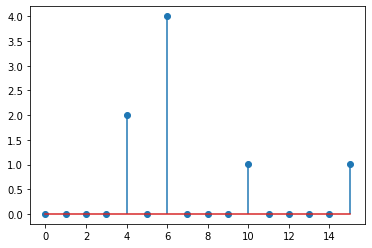

In [40]:
decoded = decode(input_signal, [M1, M2], verbose=True)
plt.stem(decoded, use_line_collection=True)

In [43]:
decoded_noiseless = decode(noiseless_signal, [M1, M2])

In [44]:
assert np.allclose(decoded_noiseless, noiseless_signal.signal_w)

In [45]:
res = decoded - input_signal.signal_w
np.inner(res, res) # should be small

0.00010325126370091587

1. Naive noisy (Maximum likelihood). Requires taking random delays and going through all the possible locations mapping to a bin, creating signatures, and decoding by MLE (take an argmax). This is good in sample complexity, but bad in time complexity.
2. SO-SPRIGHT with BCH, or with different types of codes (up to me). Need a good binary symmetric channel code (n, k, d).

Codes come with three parameters: 
- n: length of codeword, in this setting = number of delays
- k: length of thing to be recovered. Say signal length is 2^m then k = m.
- d: minimum distance. Can tolerate (d + 1) / 2 errors.

In our problem m is given; can make it larger but not smaller. Say the SNR is changing. Need to look for codes where n increases but k stays the same.

BCH may have specific lengths, adjust the signal length to fit that. Don't zero-pad for now.
BCH should work for small noise.

**References**

[1] Li, X., Ramchandran, K. (2015). An Active Learning Framework using Sparse-Graph Codes for Sparse Polynomials and Graph Sketching. NeurIPS, http://papers.neurips.cc/paper/5697-an-active-learning-framework-using-sparse-graph-codes-for-sparse-polynomials-and-graph-sketching.pdf

[2] Li, X., Bradley, J., Pawar, S., Ramchandran, K. (2015). SPRIGHT: A Fast and Robust Framework for Sparse Walsh-Hadamard Transform. arXiv.org. cs.IT. https://arxiv.org/abs/1508.06336